# Multi-Seasonal Timeseries With Covariates
This dataset is a synthetically generated collection designed to simulate complex time series forecasting scenarios with multiple seasonalities, covariates, and types. It comprises 36 condensed series, each of 160 epochs (time-steps). The dataset is structured to facilitate the development, testing, and comparison of time series forecasting models, particularly those capable of handling complex seasonal patterns and covariates.

## Components of the Dataset:

1. **Series Types (A, B, C)**: The dataset contains 36 series divided into three distinct types (A, B, and C), each comprising 12 series. The type of a series influences its behavior and characteristics, particularly the series effect applied quarterly.

2. **Pseudo-Seasonalities**:
   - **Weekly Seasonality**: Simulated with a sine wave of frequency 6 time steps, mimicking a "week" in the synthetic environment.
   - **Monthly Seasonality**: Simulated with a sine wave of frequency 30 time steps, representing a "month."
   - **Yearly Seasonality**: Simulated with a sine wave of frequency 360 time steps, capturing the "yearly" pattern.

3. **Past Covariate**: Randomly selected for 3% of the time steps in each series, this covariate represents past events known to affect future values. Each event leads to a net positive effect of +10 on the primary series 10 steps into the future.

4. **Future Covariate (Special Events)**: Also randomly selected for 3% of the time steps, these special events are intended as a future covariate, indicating known upcoming events that have a net negative effect of -10 on the primary series.

5. **Constant Bias**: Each series is influenced by a randomly sampled constant bias, adding a unique level shift to each series. This bias ranges between 25 and 50, providing a consistent offset throughout the series.

6. **Series Type Effect (Quarterly)**: Depending on the series type (A, B, or C), a specific net positive effect is added on a particular day each quarter, simulating recurring events or characteristics unique to each series type.

7. **Static Variables**: Three binary variables (`is_type_A`, `is_type_B`, `is_type_C`) indicate the type of each series, serving as static covariates to capture the series type effect.

## Utilization of the Dataset:

This dataset is particularly useful for testing and evaluating time series forecasting models that need to deal with:

- **Multiple Seasonalities**: Understanding and forecasting complex patterns that arise from overlapping seasonal effects within a shorter, focused time frame.
- **Covariate Integration**: Leveraging past, future and static covariates to improve forecasting accuracy over a specific window.


The dataset's structure allows researchers and practitioners to explore various aspects:

- **Forecasting with Exogenous Variables**: Utilizing past, future and static covariates to enhance forecasting performance in a condensed time frame.
- **Seasonality Decomposition and Analysis**: Studying models' ability to decompose and understand multiple overlapping seasonal patterns within a shorter window.
- **Impact of Irregular Events**: Evaluating how models incorporate and predict the impact of irregular, known events on future time steps within a specific window.

The final dataset is a pandas DataFrame with columns representing series ids, time steps, the main target series to forecast, and the covariates to be used fo forecasting, all within a focused window of 160 time steps. This rich, controlled environment is ideal for developing, testing, and enhancing various time series analysis and forecasting methods.

In [674]:
import numpy as np
from numpy import ndarray
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

In [675]:
dataset_name = "synthetic_multiseasonality"

In [676]:
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Functions for Data Generation


In [677]:
def generate_sine_wave(frequency: int, amplitude: float, time_steps: int) -> np.ndarray:
    """
    Generate a sine wave based on the frequency, amplitude, and number of time steps.

    Args:
        frequency (int): The number of time steps per cycle.
        amplitude (float): The amplitude of the sine wave.
        time_steps (int): The total number of time steps to generate.

    Returns:
        np.ndarray: The generated sine wave.
    """
    return amplitude * np.sin(2 * np.pi * np.arange(time_steps) / frequency)


In [678]:
def create_primary_series_with_components(time_steps: int) -> pd.DataFrame:
    """
    Create the primary series by adding three sine waves with different seasonalities and store each sine wave as a separate column.

    Args:
        time_steps (int): The total number of time steps to generate.

    Returns:
        pd.DataFrame: The primary series with separate columns for the different sine waves and the combined series.
    """
    # Frequencies and amplitude ranges for the different seasonalities
    seasonalities = [(6, (3, 4)), (30, (2, 3)), (360, (2, 3))]
    
    # Initialize the DataFrame
    series = pd.DataFrame({'time_step': np.arange(1, time_steps + 1)})
    
    # Generate and add each sine wave to the series
    primary_series = np.zeros(time_steps)
    for i, (freq, amp_range) in enumerate(seasonalities, start=1):
        sine_wave = generate_sine_wave(freq, np.random.uniform(*amp_range), time_steps)
        series[f'sine_wave_{i}'] = sine_wave
        primary_series += sine_wave
        
        series[f'seasonality{i}_idx'] = series['time_step'].apply(lambda x: x % freq)
    
    series['primary_series'] = primary_series
    
    return series


In [679]:
def add_constant_bias(series: pd.DataFrame) -> pd.DataFrame:
    """
    Add a randomly sampled constant bias to each series.

    Args:
        series (pd.DataFrame): The primary series.

    Returns:
        pd.DataFrame: The updated series with the constant bias added.
    """
    # Sample a constant bias value between 25 and 50 for the entire series
    constant_bias = np.random.uniform(25, 50)
    
    # Create a column 'bias' and set it to the constant bias value
    series['bias'] = constant_bias

    return series


In [680]:
def add_past_covariate(series: pd.DataFrame) -> pd.DataFrame:
    """
    Add a past covariate for the series, indicating past events and their values with a lag.

    Args:
        series (pd.DataFrame): The primary series.

    Returns:
        pd.DataFrame: The updated series with the past covariate added.
    """
    # Initialize the 'past_covariate_event' and 'past_covariate_event_value' columns with default values
    series['past_covariate_event'] = 0
    series['past_covariate_event_value'] = 0

    # Randomly pick 5% of the time steps to be past covariate events
    num_events = int(len(series) * 0.03)
    event_indices = np.random.choice(series.index[:-10], num_events, replace=False)  # Exclude last 10 to avoid index overflow

    # Set 'past_covariate_event' to 1 for these events
    series.loc[event_indices, 'past_covariate_event'] = 1

    # Set 'past_covariate_event_value' to +10, 10 time steps after the event
    for index in event_indices:
        series.at[index + 10, 'past_covariate_event_value'] = 10

    return series

In [681]:
def add_future_covariate(series: pd.DataFrame) -> pd.DataFrame:
    """
    Create a future covariate for the series, indicating special events and their values.

    Args:
        series (pd.DataFrame): The primary series.

    Returns:
        pd.DataFrame: The updated series with the future covariate added.
    """
    # Initialize the 'is_special_event' and 'special_event_value' columns with default values
    series['is_special_event'] = 0
    series['special_event_value'] = 0

    # Randomly pick 5% of the time steps to be special events
    num_special_events = int(len(series) * 0.03)
    special_event_indices = np.random.choice(series.index, num_special_events, replace=False)

    # Set 'is_special_event' to 1 and 'special_event_value' to -10 for these special events
    series.loc[special_event_indices, 'is_special_event'] = 1
    series.loc[special_event_indices, 'special_event_value'] = -10

    return series

In [682]:
def add_series_type_effect(series: pd.DataFrame, series_type: str) -> pd.DataFrame:
    """
    Add the series type effect to the primary series based on the series type and store the intermediate column.

    Args:
        series (pd.DataFrame): The primary series.
        series_type (str): The type of the series ('A', 'B', or 'C').

    Returns:
        pd.DataFrame: The updated series with the series type effect added.
    """
    # Define the day of the month to add the effect for each series type
    effect_days = {'A': 1, 'B': 31, 'C': 61}
    
    # Add a 90 step counter
    series['series_type_effect_idx'] = series['time_step'].apply(lambda x: (x-1) % 90 + 1)
    
    # Initialize the series type effect column
    series['series_type_effect'] = 0
    
    # Add the effect to the series
    for day in range(effect_days[series_type], len(series), 90):  # Every quarter
        series.loc[series['time_step'] == day, 'series_type_effect'] = 20
    
    return series

In [683]:
def add_noise(series: pd.DataFrame) -> pd.DataFrame:
    """
    Add random noise to the primary series and store the intermediate column.

    Args:
        series (pd.DataFrame): The primary series.

    Returns:
        pd.DataFrame: The updated series with noise added.
    """
    noise = np.random.normal(0, .15, len(series))
    series['noise'] = noise    
    return series

In [684]:
def select_random_window(series: pd.DataFrame, window_size: int = 160) -> pd.DataFrame:
    """
    Randomly select a window of specified size from the series and reset the time_steps.

    Args:
        series (pd.DataFrame): The primary series.
        window_size (int): The size of the window to select.

    Returns:
        pd.DataFrame: The updated series with the selected window and reset time steps.
    """
    # Ensure the series is long enough for the specified window size
    if len(series) < window_size:
        raise ValueError("The series is shorter than the specified window size.")

    # Randomly select a start index for the window
    start_index = np.random.randint(0, len(series) - window_size + 1)
    
    # Select the window from the series
    window = series.iloc[start_index:start_index + window_size].copy()
    
    # Reset the time_steps column to go from 1 to window_size
    window['time_step'] = np.arange(1, window_size + 1)
    
    # Reset index
    window.reset_index(drop=True, inplace=True)

    return window

In [685]:
def create_synthetic_series() -> pd.DataFrame:
    """
    Create a synthetic time series dataset with 36 series, various effects, intermediate columns, and original sine waves.

    Returns:
        pd.DataFrame: The final time series dataset with 36 series, 720 time steps each, and all details.
    """
    time_steps = 720
    final_data = []
    for series_id in range(36):
        # Create the primary series with separate sine wave components
        series = create_primary_series_with_components(time_steps)
        series['value'] = series['primary_series']
        
        # Add a constant bias to the series 
        series = add_constant_bias(series)
        series['value'] += series['bias']
        
        # Add past covariate
        series = add_past_covariate(series)
        series['value'] += series['past_covariate_event_value']
        
        # Add future covariate
        series = add_future_covariate(series)
        series['value'] += series['special_event_value']        
        
        # Determine the series type and add the series type effect
        if series_id < 12:
            series_type = 'A'            
        elif series_id < 24:
            series_type = 'B'
        else:
            series_type = 'C'            
        series = add_series_type_effect(series, series_type)
        series['value'] += series['series_type_effect']
        
        # Add noise
        series = add_noise(series)
        series['value'] += series['noise']
        
        # Add series ID 
        series_name = f"series_{series_type}{series_id % 12 + 1}"
        series.insert(0, 'series_id', series_name)
        
        # Add series type flags
        series['is_type_A'] = 1 if series_type == 'A' else 0
        series['is_type_B'] = 1 if series_type == 'B' else 0
        series['is_type_C'] = 1 if series_type == 'C' else 0
        
        # Select random window 
        series_window = select_random_window(
            series, window_size=160)
        
        final_data.append(series_window)
    
    return pd.concat(final_data).reset_index(drop=True)

np.random.seed(0)

# Generate the synthetic time series dataset with all details including the original sine waves
synthetic_data = create_synthetic_series()
synthetic_data.head(15)

,series_id,time_step,sine_wave_1,seasonality1_idx,sine_wave_2,seasonality2_idx,sine_wave_3,seasonality3_idx,primary_series,value,...,past_covariate_event,past_covariate_event_value,is_special_event,special_event_value,series_type_effect_idx,series_type_effect,noise,is_type_A,is_type_B,is_type_C
0,series_A1,1,4.172641e-14,4,-2.582299e+00,22,-0.932747,202,-3.515046,35.121617,...,0,0,0,0,22,0,0.014583,1,0,0
1,series_A1,2,-3.073363e+00,5,-2.700315e+00,23,-0.975012,203,-6.748690,32.025739,...,0,0,0,0,23,0,0.152350,1,0,0
2,series_A1,3,-3.073363e+00,0,-2.700315e+00,24,-1.016981,204,-6.790659,41.936577,...,0,10,0,0,24,0,0.105156,1,0,0
3,series_A1,4,-7.998477e-14,1,-2.582299e+00,25,-1.058639,205,-3.640938,34.918520,...,0,0,0,0,25,0,-0.062622,1,0,0
4,series_A1,5,3.073363e+00,2,-2.351423e+00,26,-1.099975,206,-0.378036,38.079419,...,0,0,0,0,26,0,-0.164624,1,0,0
5,series_A1,6,3.073363e+00,3,-2.017779e+00,27,-1.140976,207,-0.085393,38.793533,...,0,0,0,0,27,0,0.256846,1,0,0
6,series_A1,7,1.182431e-13,4,-1.595948e+00,28,-1.181630,208,-2.777578,35.725684,...,0,0,0,0,28,0,-0.118817,1,0,0
7,series_A1,8,-3.073363e+00,5,-1.104367e+00,29,-1.221923,209,-5.399653,33.065598,...,0,0,0,0,29,0,-0.156829,1,0,0
8,series_A1,9,-3.073363e+00,0,-5.645196e-01,0,-1.261845,210,-4.899727,33.559624,...,0,0,0,0,30,0,-0.162728,1,0,0
9,series_A1,10,4.522521e-14,1,-4.655207e-15,1,-1.301382,211,-1.301382,37.488294,...,0,0,0,0,31,0,0.167596,1,0,0


In [686]:
synthetic_data.columns

Index(['series_id', 'time_step', 'sine_wave_1', 'seasonality1_idx',
       'sine_wave_2', 'seasonality2_idx', 'sine_wave_3', 'seasonality3_idx',
       'primary_series', 'value', 'bias', 'past_covariate_event',
       'past_covariate_event_value', 'is_special_event', 'special_event_value',
       'series_type_effect_idx', 'series_type_effect', 'noise', 'is_type_A',
       'is_type_B', 'is_type_C'],
      dtype='object')

In [687]:
series_col = "series_id"
epoch_col = 'time_step'
time_col = ''
value_col = 'value'
exog_cols=[
    
    # past covariate - helpful for forecasting values its effect 10 steps out
    'past_covariate_event',
    
    # future covariate
    # the following should aid the models in learning the series effect which occurs once on a specific day
    # every quarter depending on the series type
    'series_type_effect_idx',
    
    # also future covariate, this is necessary feature since it has a net -10 value, and it is irregular
    # in occurrence, so cannot be predicted
    'is_special_event',
    
    # these will serve as static covariates - 
    # helpful for detecting the series effect which occurs every 90th time step
    'is_type_A', 'is_type_B', 'is_type_C',
    
  ]

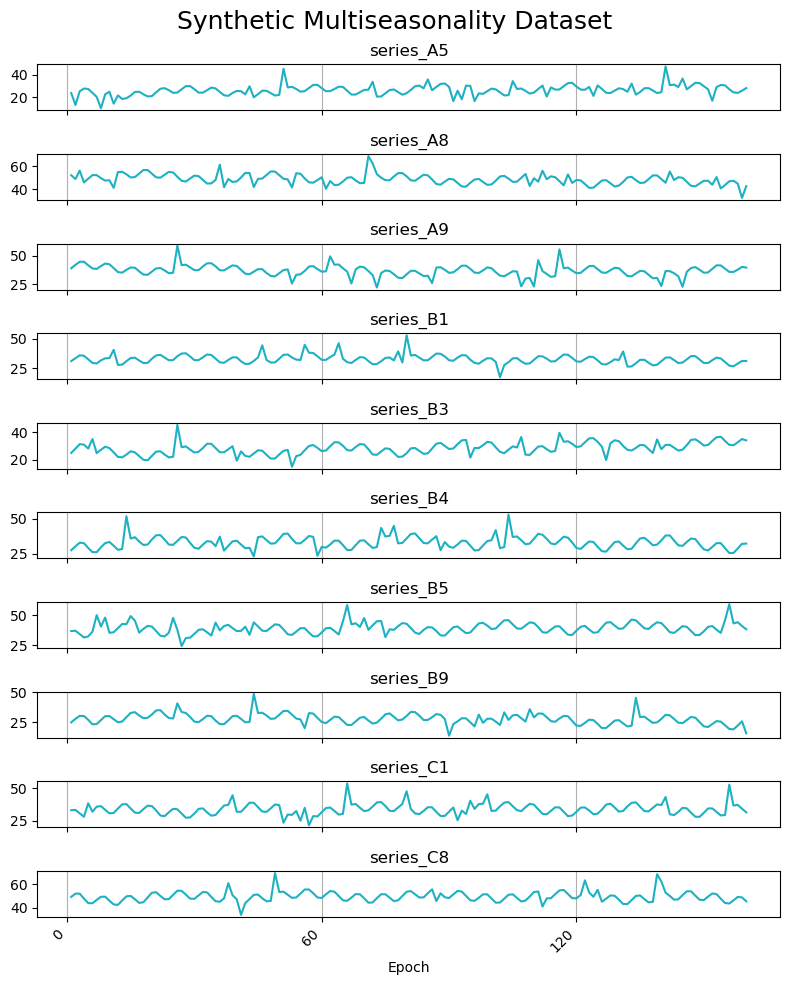

In [688]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import random 

random.seed(1)

def plot_trends(df, series_col, val_col, epoch_col, epoch_label, num_series=10,
                filepath=outp_fig_fname, chart_title=dataset_name):
    """
    This function takes a dataframe and a number of series to chart.
    It creates a n x 1 subplot (with n being the number of series, at most 10) and plots those series.
    
    Parameters:
    df (DataFrame): dataframe.
    num_series (int): The number of series to plot, defaulted to 10.
    """
    
    # Get the unique series from the dataframe
    unique_series = list(df[series_col].unique())
    
    # Limit the number of series to plot
    num_to_plot = min(len(unique_series), num_series)
    series_to_plot = sorted(random.sample(unique_series,num_to_plot)) # unique_series[:num_to_plot]
    
    # Set up the subplots
    fig, axes = plt.subplots(nrows=min(num_series, len(series_to_plot)), ncols=1, figsize=(8, num_series*1))
    
    # If there's only one series to plot, axes will not be an array, so we wrap it in a list
    if num_series == 1:
        axes = [axes]
    
    # Define the color for the plots
    plot_color = '#1db1c1'
    
    # Plot each series on a separate subplot
    for i, (ax, series_id) in enumerate(zip(axes, series_to_plot)):
        # Filter the dataframe for the current series
        series_data = df[df[series_col] == series_id]
                
        # Plot the data
        ax.plot(series_data[epoch_col], series_data[val_col], color=plot_color)
        
        # Set the title and labels
        ax.set_title(series_id)
        
        # Set x-axis ticks to appear every 5th point
        ax.xaxis.set_major_locator(MultipleLocator(60))
        
        # ax.set_ylabel('Trend')
        # Show x-axis grid
        ax.xaxis.grid(True)
        
        # Show x-axis labels only for the last (bottom) plot
        if i < len(series_to_plot) - 1:
            ax.set_xticklabels([])
        else:
            # Rotate date labels to avoid overlap
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            ax.set_xlabel(epoch_label)            
        
        # Rotate date labels to avoid overlap
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle(chart_title, fontsize=18)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Save figure
    plt.savefig(filepath)
    
    plt.show()
# Plot a few series
plot_trends(
    synthetic_data,
    series_col=series_col,
    val_col=value_col,
    epoch_col=epoch_col,
    epoch_label='Epoch',
    num_series=10,
    filepath=outp_fig_fname,
    chart_title="Synthetic Multiseasonality Dataset"
)  


# Save Main Data File

In [689]:
all_cols = [series_col, epoch_col, value_col] + exog_cols    
synthetic_data.sort_values(by=[series_col, epoch_col], inplace=True)
synthetic_data[all_cols].to_csv(outp_fname, index=False, float_format="%.4f")

In [690]:
synthetic_data.shape

(5760, 21)